In [1]:
import mdtraj
import jraph
import jax
import numpy as np
import jax.numpy as jnp
import itertools
import haiku as hk
from mdtraj.core.trajectory import Trajectory
from typing import List

ref_fname = 'alanine-dipeptide-nowater.pdb'
traj_fname = 'alanine-dipeptide-0-250ns-nowater.xtc'

In [2]:
# load the file and inspect sliced subtraj
ref = mdtraj.load(ref_fname)
traj = mdtraj.load_xtc(traj_fname, top=ref.topology)
traj[::10000].save('sliced.pdb')

In [3]:
def rbf_featurizer(distances: jnp.array, r_cut, n_feat=20) -> jnp.array:
    """
    input: T * N_interactions
    output: T * N_inter * N_feat
    """
    planes = []
    for n in range(1, n_feat+1):
        plane = jnp.sin(n*jnp.pi/r_cut*distances) / jnp.linalg.norm(distances)
        planes.append(plane[:,:, None])
    return jnp.concatenate(tuple(planes), axis=2)


In [4]:
def get_auxiliary_data(traj: Trajectory, 
                       ref: Trajectory, 
                       cutoff = 0.65,
                       n_rbf_feats = 20):
    """
    Returns auxiliary data for building proximity graphs of MD sampled conformations
    atomic_type_feature: n_atoms * n_atom_types
    atom_pair_idx: n_pairs * 2 array
    cutoff_condition: T * n_pairs array
    distances: T * n_pairs array
    rbf_features: T * n_pairs * n_feats
    """
    # get number of atoms and make onehot encoding 
    atomic_nums = list([atom.element.atomic_number for atom in ref.topology.atoms])
    unique_atomic_nums = list(set(atomic_nums))
    unique_atomic_nums.sort()
    n_atom_type = len(unique_atomic_nums)

    # we need to map unique atomic numbers to ids 0,1,2,..., n_atom_types
    to_atomic_id = dict(zip(unique_atomic_nums, range(n_atom_type)))
    atomic_ids = list(map(lambda num: to_atomic_id[num], atomic_nums))
    atomic_type_feature = jax.nn.one_hot(atomic_ids, n_atom_type) # node features, n_atoms * n_atom_types

    # compute all interatomic distances
    n_atoms = ref.topology.n_atoms
    atom_pair_idx = jnp.array(list(itertools.combinations(range(n_atoms), 2)))
    distances = jnp.array(mdtraj.compute_distances(traj[:], atom_pair_idx))

    cutoff_condition = distances < cutoff
    rbf_features = rbf_featurizer(distances, cutoff, n_rbf_feats)
    
    return atomic_type_feature, atom_pair_idx, cutoff_condition, distances, rbf_features

In [5]:
# get proximity graphs based on distance cutoff
# for efficiency we transform an entire trajectory at once

def to_proximity_graphs(traj: Trajectory, 
                        ref: Trajectory,
                        cutoff = 0.65,
                       n_rbf_feats = 20) -> jraph.GraphsTuple:
    # compute auxiliary data over the entire trajectory
    atomic_type_feature, atom_pair_idx, cutoff_condition, distances, distance_rbf_feature = \
            get_auxiliary_data(traj, ref, cutoff=cutoff)
    n_atoms = ref.topology.n_atoms
    
    # iterate by frame to assemble graphs
    graphs = []
    
    # well, unjittable...
    def to_proximity_graph(frame_id):
        slice_idx = cutoff_condition[frame_id]
        atom_pair_subset = atom_pair_idx[slice_idx]
        distance_subset = distances[frame_id, slice_idx]
        n_interactions = len(distance_subset)
    
        proximity_graph = jraph.GraphsTuple(n_node=jnp.array([n_atoms]), 
                                            n_edge=jnp.array([2*n_interactions]), 
                                            nodes=atomic_type_feature, 
                                            edges=jnp.concatenate((distance_rbf_feature[frame_id, slice_idx, :],
                                                                   distance_rbf_feature[frame_id, slice_idx, :])),
                                            globals=None, 
                                            senders=jnp.concatenate((atom_pair_subset[:,0], 
                                                                     atom_pair_subset[:,1])), 
                                            receivers=jnp.concatenate((atom_pair_subset[:,1], 
                                                                       atom_pair_subset[:,0])))
        return proximity_graph
    
    for frame_id in range(len(traj)):
        graphs.append(to_proximity_graph(frame_id))
        
    return graphs


In [6]:
%%time
training_dataset = to_proximity_graphs(traj[:100], ref)

CPU times: user 2.64 s, sys: 65.7 ms, total: 2.71 s
Wall time: 2.7 s


Next, we need to prepare the reference position for the output of the flow model. The approach is that we first specify a linear coarse graining map that takes the average (in what sense?) position of all atoms in each cluster to get a proposal CG conformation. We then use the positional average over all proposal CG confotmations as the reference position. This is similar to the idea of whitening input coordinates for the Boltzmann model.

In [7]:
# define proposal CG map as a list of lists
# will hard-code for ala-2 system by group together atoms in each residue

clusters = [[0,1,2,3,4,5],[6,7,8,9,10,11,12,13,14,15],[16,17,18,19,20,21]]

# we use geometric average
proposal_cg_traj = jnp.concatenate(tuple([np.mean(traj.xyz[:, cluster, :], axis=1)[:, None, :] \
                                            for cluster in clusters]), axis=1)

proposal_cg_ref = jnp.mean(proposal_cg_traj, axis=0)
proposal_cg_ref # n_cg_beads * 3

DeviceArray([[ 3.0695120e-01,  2.6453381e+00,  1.8181525e-01],
             [ 2.9560649e-01,  2.3439131e+00, -5.1674754e-03],
             [ 1.8006748e-03,  2.1605999e+00,  7.8072831e-02]],            dtype=float32)

We also need to define the CG energy function based on the ENM that stores global parameters of spring constant as well as equilibrium length for all C(n_cg, 2) edges, assuming a complete graph.

In [8]:
N=3
N_ints=N*(N-1)//2

x=jax.random.normal(jax.random.PRNGKey(42), shape=(N, 3))
d_eq=jax.random.normal(jax.random.PRNGKey(43), shape=(N_ints,))
k=jax.random.normal(jax.random.PRNGKey(44), shape=(N_ints,))
edges=jnp.array(list(itertools.combinations(range(N), 2)))

In [9]:
class CG_energy(hk.Module):
    def __init__(self, N, d_eq0: jnp.array, k=None, name=None):
        super().__init__(name=name)
        self.edges = jnp.array(list(itertools.combinations(range(N), 2)))
        self.n_edges = N*(N-1)//2
        k_init = jnp.ones if k is None else lambda a,b: k
        self.k = hk.get_parameter("k", [self.n_edges], init=k_init)
        self.d_eq0 = d_eq0
        self.d_eq = hk.get_parameter("d_eq", [self.n_edges], init=jnp.zeros)
        
    def __call__(self, x):
        dx_ij = jnp.diff(x[self.edges], axis=1)[:, 0, :]
        d_ij = jnp.linalg.norm(dx_ij, axis=-1)
        E = 0.5 * np.sum(self.k * (d_ij - self.d_eq - self.d_eq0) ** 2)
        return E

In [10]:
dx_ij0 = jnp.diff(proposal_cg_ref[edges], axis=1)[:, 0, :]
d_ij0 = jnp.linalg.norm(dx_ij0, axis=-1)
efun = hk.without_apply_rng(hk.transform(lambda x: CG_energy(N=3, d_eq0=d_ij0)(x) ))

In [11]:
params = efun.init(rng=jax.random.PRNGKey(42), x=proposal_cg_ref)
E = efun.apply(params, x)
E

DeviceArray(2.9004967, dtype=float32)

In [12]:
params

{'cg_energy': {'k': DeviceArray([1., 1., 1.], dtype=float32),
  'd_eq': DeviceArray([0., 0., 0.], dtype=float32)}}

In [13]:
# first we define the GNN part, which consists of featurizer, mp layers, and readout

class GraphNetwork(hk.Module):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(name=name)
        self.model = jraph.GraphNetwork(*args, **kwargs)
    
    def __call__(self, g: jraph.GraphsTuple) -> jraph.GraphsTuple:
        return self.model(g)
    
class GraphEncoder(hk.Module):
    """
    Encodes input Fine-Grained (FG) molecular graph and outputs a
    continuous vector embedding of that graph deterministically.
    """
    def __init__(self, n_layers: int, 
                       n_hidden: int,
                       edge_embedding_size: int,
                       node_embedding_size: int,
                       clusters: List[List],
                       n_nodes: int,
                       name=None):
        super().__init__(name=name)
        self.n_layers = n_layers
        self.clusters = [jnp.array(cluster) for cluster in clusters]
        self.n_nodes = n_nodes
        edge_output_sizes = [n_hidden, edge_embedding_size]
        node_output_sizes = [n_hidden, node_embedding_size]
#         def make_embed_edge_fn(activation=jax.nn.relu):
#             def f(edge_feats): # single layer for simplicity
#                 return hk.nets.MLP([edge_embedding_size], activation=activation)(edge_feats)
#             return f
        
        def make_embed_node_fn(activation=jax.nn.relu):
            def f(node_feats):
                return hk.nets.MLP([node_embedding_size], activation=activation)(node_feats)
            return f
        
        def make_update_edge_fn(activation=jax.nn.relu):
            @jraph.concatenated_args
            def f(feats):
                return hk.nets.MLP(edge_output_sizes, activation=activation)(feats)
            return f
        
        def make_update_node_fn(activation=jax.nn.relu):
            def f(node_feats, sender_feats, receiver_feats, global_feats):
                return hk.nets.MLP(node_output_sizes, activation=activation)(
                    jnp.concatenate([node_feats, receiver_feats], axis=1) # only aggr over msgs from incoming edges
                )
            return f
        
        # simple idea is to aggregate in each cluster and then return
        def make_aggr_global_fn():
            def f(node_feats, seg_ids, n_seg):
                jax.debug.print(repr(node_feats.shape))
                global_feats = []
                for i in range(n_seg):
                    offset = i*n_nodes
                    global_feats.append(jnp.vstack([jnp.mean(node_feats[offset+cluster, :], axis=0) \
                                                    for cluster in self.clusters])[None, :, :])
                global_feats = jnp.concatenate(global_feats, axis=0)
                jax.debug.print(repr(global_feats))
                return global_feats
            return f
        
        def make_update_global_fn():
            def f(node_feats, edge_feats, global_feats):
                return node_feats
            return f
        
        self.featurizer = jraph.GraphMapFeatures(embed_edge_fn=None,
                                                 embed_node_fn=make_embed_node_fn(), 
                                                 embed_global_fn=None)
        self.mp_layers = [GraphNetwork(update_edge_fn=make_update_edge_fn(), 
                                       update_node_fn=make_update_node_fn(), 
                                       update_global_fn=None) for _ in range(n_layers)]
        self.readout = GraphNetwork(update_edge_fn=None, 
                                    update_node_fn=None, 
                                    update_global_fn=make_update_global_fn(),
                                   aggregate_nodes_for_globals_fn=make_aggr_global_fn())
        
    def __call__(self, g: jraph.GraphsTuple):
        g = self.featurizer(g)
        for layer in self.mp_layers:
            g = layer(g)
        jax.debug.print(repr(g.nodes.shape))
        g = self.readout(g)
        return g.nodes, g.globals # extract graph level latent feature
        


In [14]:
gnn = hk.without_apply_rng(hk.transform(lambda g: GraphEncoder(n_layers=1,
                                                               n_hidden=16,
                                                               edge_embedding_size=20,
                                                               node_embedding_size=8,
                                                               clusters=clusters,
                                                               n_nodes=22)(g)))

In [15]:
params = gnn.init(jax.random.PRNGKey(42), g=training_dataset[0])


(22, 8)
(22, 8)
DeviceArray([[[ 0.36294484, -1.1550834 , -1.3745722 ,  0.89994156,
                0.35616946, -1.0738015 , -1.4721186 ,  0.02051747],
              [ 0.4009571 , -1.141149  , -1.4922091 ,  0.8650738 ,
                0.52784985, -0.8994447 , -1.5078456 , -0.08370405],
              [ 0.37083656, -0.9308739 , -1.7783154 ,  0.6017302 ,
                0.97250926, -0.51505244, -1.4223316 , -0.20902091]]],            dtype=float32)


In [16]:
@jax.jit
def gnn_fun(batch):
    return gnn.apply(params, batch)

node_feats, global_feat = gnn_fun(batch=training_dataset[0])

(22, 8)
(22, 8)
Traced<ShapedArray(float32[1,3,8])>with<DynamicJaxprTrace(level=0/1)>


Next we pass the aggregated feature from each cluster through networks that we simply take to be a shallow MLP. We will use two networks for each cluster to parametrize the mean and std of the conditional gaussian in $\mathbb{R}^3$.

In [17]:
class LatentPosteriorParametrizer(hk.Module):
    def __init__(self, n_cg_nodes, n_hidden, name=None):
        super().__init__(name=name)
        self.n_cg_nodes = n_cg_nodes
        self.output_sizes = [n_hidden, 3]
        self.mu_nets = [hk.nets.MLP(self.output_sizes) for _ in range(self.n_cg_nodes)]
        self.sig_nets = [hk.nets.MLP(self.output_sizes) for _ in range(self.n_cg_nodes)]
        
    def __call__(self, z):
        """
        z is the embedding from the encoder network of dim 
        batch_size * n_cg_nodes * node_embedding size
        
        outputs flat params of shape batch_size * (n_cg_nodes * 3)
        """
        
        # apply mu, sig nets to the corresponding slice of z for ith cg node feature
        mu_planes = [self.mu_nets[i](z[:, i, :]) for i in range(self.n_cg_nodes)]
        sig_planes = [self.sig_nets[i](z[:, i, :]) for i in range(self.n_cg_nodes)]
        return jnp.concatenate(mu_planes, axis=1), \
               jnp.concatenate(sig_planes, axis=1)
    

In [18]:
parametrizer = hk.without_apply_rng(hk.transform(lambda z: LatentPosteriorParametrizer(n_cg_nodes=3,
                                                                                       n_hidden=8)(z) ))
parametrizer_params = parametrizer.init(jax.random.PRNGKey(42), z=global_feat)
mu_params, sig_params = parametrizer.apply(parametrizer_params, z=global_feat)
mu_params.shape, sig_params.shape

((1, 9), (1, 9))

Mimicking the conjugate gradient descent idea, our training loop will consist of two steps:

1. Fixing the CG energy function, we generate some samples from the Boltzmann distribution as well as random latent features from the Gaussian distribution. We use a weighted KL loss to train this flow model.

2. Fixing the flow model, we train with FG MD trajectory and jointly optimize the encoder, decoder, and the energy function.

We now implement the first step and test it on a 5 bead, 10 interactions tetrahedral structure with two metastable states. 

In [19]:
# setting up the energy function and reference configuration
test_cg_ref = jnp.array([[1, 1, 1],
                         [-1, -1, 1],
                         [-1, 1, -1],
                         [1, -1, -1],
                         [-1/3, 1/3, 1/3]]) # tetrahedron with an extra face center

test_cg_ref_meta1 = jnp.array([[1, 1, 1],
                         [-1, -1, 1],
                         [-1, 1, -1],
                         [1, -1, -1],
                         [0, 0, 0]])

test_cg_ref_meta2 = jnp.array([[1, 1, 1],
                         [-1, -1, 1],
                         [-1, 1, -1],
                         [1, -1, -1],
                         [-2/3, 2/3, 2/3]])

test_cg_ref_interm = jnp.array([[1, 1, 1],
                         [-1, -1, 1],
                         [-1, 1, -1],
                         [1, -1, -1],
                         [-1/4, 1/4, 1/4]])

test_cg_edges = jnp.array(list(itertools.combinations(range(5), 2)))
test_cg_eq_length = jnp.linalg.norm(jnp.diff(test_cg_ref[test_cg_edges], axis=1)[:, 0, :], axis=1)
print(test_cg_eq_length)
test_cg_k = jnp.ones_like(test_cg_eq_length)*100
test_cg_eq_length = test_cg_eq_length.at[jnp.array([3, 6, 8])].set(jnp.sqrt(3))
test_cg_k = test_cg_k.at[jnp.array([-1])].set(0)
print(test_cg_eq_length, test_cg_k)
test_cg_efun = hk.without_apply_rng(hk.transform(lambda x: CG_energy(N=5, d_eq0=test_cg_eq_length,
                                                                          k=test_cg_k)(x) ))
test_cg_efun_params = test_cg_efun.init(rng=jax.random.PRNGKey(42), x=jnp.zeros(shape=(5, 3)))
print(test_cg_efun_params)
print(test_cg_efun.apply(test_cg_efun_params, test_cg_ref))
print(test_cg_efun.apply(test_cg_efun_params, test_cg_ref_meta1))
print(test_cg_efun.apply(test_cg_efun_params, test_cg_ref_meta2))
print(test_cg_efun.apply(test_cg_efun_params, test_cg_ref_interm))

[2.828427  2.828427  2.828427  1.6329932 2.828427  2.828427  1.6329932
 2.828427  1.6329932 2.309401 ]
[2.828427  2.828427  2.828427  1.7320508 2.828427  2.828427  1.7320508
 2.828427  1.7320508 2.309401 ] [100. 100. 100. 100. 100. 100. 100. 100. 100.   0.]
{'cg_energy': {'k': DeviceArray([100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.],            dtype=float32), 'd_eq': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}}
1.4718598
0.0
2.1316282e-12
1.2887483


In [20]:
# magic!! hand wave!!

import sys
sys.path.insert(0,'..')
from importlib import reload # python 2.7 does not require this

import models.RealNVP_distrax
import matplotlib.pyplot as plt
reload( models.RealNVP_distrax )
from models.RealNVP_distrax import make_forward_reverse_flow_models, make_KL_loss_funs, \
                                   make_base_dist, make_grouped_affine_coupling_flow

n_particles = 5
n_spatial_dim = n_particles * 3 - 6 # remove trans, rot

In [137]:
@jax.jit
def efun(batch):
    
    @jax.vmap
    def efun_inner(conf):
        conf = conf.reshape((n_particles, 3))
        conf = conf + test_cg_ref_meta1 # broadcast, align last two dims
        return test_cg_efun.apply(test_cg_efun_params, conf)
    
    unanchored = unanchor(batch)
    return efun_inner(unanchored)


base_dist = make_base_dist(event_shape=[n_spatial_dim])
forward_model, reverse_model = make_forward_reverse_flow_models(make_flow_model=make_grouped_affine_coupling_flow, 
                                                                event_shape=[n_spatial_dim],
                                                                coupling_group_size=3,
                                                                num_layers=6,
                                                                hidden_sizes = [16, 16, n_spatial_dim])
forward_KL, reverse_KL, combined_KL = make_KL_loss_funs(forward_model, reverse_model, 
                                                        energy_fun=efun, 
                                                        base_dist=base_dist)



3/9/23 after talking to Minhuan, I decided to write the code for anchoring (3N to 3N-6 coordinates) and deanchoring (3N-6 to 3N coordinates) conformations.

In [138]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / jnp.linalg.norm(vec1)).reshape(3), (vec2 / jnp.linalg.norm(vec2)).reshape(3)
    v = jnp.cross(a, b)
    c = jnp.dot(a, b)
    s = jnp.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = jnp.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def anchor(batch):
    # input is n_batch * 3N (N>2)
    # output is n_batch * 3N-6 array
    n_batch = batch.shape[0]
    v1 = batch[:, 0:3] # translate
    v2 = batch[:, 3:6] # rotate
    v3 = batch[:, 6:9] # rotate
    
    # construct coordinate frames
    n0 = jnp.array([[0, 0, 1] * n_batch])
    n = jnp.cross(v1 - v2, v3 - v2) 
    n /= jnp.linalg.norm(n, axis=1)
    a0 = jnp.linalg.norm(v1-v2, axis=1) * jnp.array([[1, 0, 0]])
    a = v2-v1
    b0 = jnp.cross(a0, n0)
    b = jnp.cross(a, n)
    m0 = jnp.stack([n0, a0, b0], axis=1) 
    m = jnp.stack([n, a, b], axis=1)
    inv = jnp.linalg.inv(m)
    rot_mat = inv @ m0
    adjusted = (batch.reshape((n_batch, -1, 3)) - v1) @ rot_mat
    anchored = jnp.delete(adjusted.reshape((n_batch, -1)), jnp.array([0, 1, 2, 4, 5, 8]), axis=1)
    return v1, rot_mat, anchored

def unanchor(batch, trans=None, rot_mat=None):
    n_batch = batch.shape[0]
    inflated = jnp.insert(batch, jnp.array([0, 0, 0, 1, 1, 3]), jnp.zeros(shape=(n_batch, 6)), axis=1)
    unanchored = inflated
    if trans is not None and rot_mat is not None:
        inflated = inflated.reshape((n_batch, -1, 3))
        unanchored = (inflated @ jnp.transpose(rot_mat, axes=(0, 2, 1))) + trans
        unanchored = unanchored.reshape((n_batch, -1))
    return unanchored
    

In [139]:
test_cg_ref_reshaped = test_cg_ref.reshape((1, 15))
trans_vec, rot_mat, result = anchor(test_cg_ref_reshaped)
test_cg_ref_recovered = unanchor(result, trans_vec, rot_mat)
assert (jnp.abs(test_cg_ref_reshaped-test_cg_ref_recovered) < 1e-6).all()

In [252]:
def adaptive_fit(params, optimizer, epochs, training_data, rng_key, efun=efun, 
                 sigma_range=[0.1, 1], 
                 log_beta_range=[-3, 0], 
                 warm_up_epochs=100):
    opt_state = optimizer.init(params)
    
    
    @jax.jit
    def step_(params, opt_state, batch):
        loss_value, grads = jax.value_and_grad(forward_KL)(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    @jax.jit
    def step(params, opt_state, batch, beta, sigma, rng_key):
        x_batch, rand_z_batch = batch
        rng_key, *subkeys = jax.random.split(rng_key, 3)
        z_batch, log_proba_xz = reverse_model.apply(params, x_batch)
        z_batch_new = z_batch + jax.random.normal(key=subkeys[0], shape=x_batch.shape) * sigma
        x_batch_new, log_proba_new_zx = forward_model.apply(params, z_batch_new)
        
        delta_E = efun(x_batch_new) - efun(x_batch)
        delta_log_zx_proba = log_proba_new_zx + log_proba_xz
        
        # update entire batch
        mask = jax.random.uniform(key=subkeys[1]) <= jnp.minimum(1, jnp.exp(-beta*delta_E + delta_log_zx_proba)) # kb=1
        mask = mask[:, None] # prepares for broadcast
        x_batch_updated = mask * x_batch_new + (1-mask) * x_batch
            
        loss_value, grads = jax.value_and_grad(combined_KL)(params, x_batch, rand_z_batch, beta)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value, x_batch_updated, rng_key

    def reporter(epoch, loss, frequency):
        print(f'Epoch {epoch}, loss: {loss_value}')
        if epoch % frequency == 0:
            plt.hist(efun(training_data[0]), bins=100)
            plt.show()
            plot_latent_space(forward_model, params)
            plt.show()
    
        
    @jax.jit
    def get_random_data(rng_key):
        random_data = jax.random.normal(subkey, shape=training_data.shape)
        return random_data
    
    for epoch in range(warm_up_epochs):
        epoch_loss = 0
        for batch in training_data:
            params, opt_state, loss_value = step_(params, opt_state, batch)
            epoch_loss += loss_value
        epoch_loss /= len(training_data)
        reporter(epoch, epoch_loss, 10)
    
    for epoch, sigma, beta in zip(range(epochs),
                                  jnp.linspace(sigma_range[0], sigma_range[1], epochs),
                                  jnp.logspace(log_beta_range[0], log_beta_range[1], epochs)):
        rng_key, subkey = jax.random.split(rng_key, 2)
        random_data = get_random_data(subkey)
        epoch_loss = 0
        for i, batch in enumerate(zip(training_data, random_data)):
            params, opt_state, loss_value, x_batch_updated, rng_key = step(params, opt_state, batch, beta, sigma, rng_key)
            training_data = training_data.at[i].set(x_batch_updated)
            epoch_loss += loss_value
        epoch_loss /= len(training_data)    
        reporter(epoch, epoch_loss, 50)
    
        
    return params, training_data

In [234]:
def sample(length, init, seed=42, sigma=0.1, beta=1):
    traj = [init]
    energy = [efun(init)[0]]
    rng_key = jax.random.PRNGKey(seed)
    
    @jax.jit # seems pretty fast
    def aux(rng_key):
        next_state = jnp.array(traj[-1])
        rng_key, key = jax.random.split(rng_key, 2)
        next_state += jax.random.normal(key=key, shape=next_state.shape)*sigma
        E_last = efun(traj[-1])
        E_curr = efun(next_state)
        rng_key, key = jax.random.split(rng_key, 2)
        return rng_key, E_last, E_curr, next_state
    
    while length > 1:
        rng_key, E_last, E_curr, next_state = aux(rng_key)
        rng_key, key = jax.random.split(rng_key, 2)
        if jax.random.uniform(key) <= jnp.minimum(1, np.exp(-beta*(E_curr-E_last))): # kb=1
            traj.append(next_state)
            energy.append(E_curr)
            length-=1
    return jnp.array(traj[1:])[:, 0, :], jnp.array(energy[1:])[:, 0]

In [237]:
traj, energy = sample(5_0001, jnp.zeros((1, 9)))

KeyboardInterrupt: 

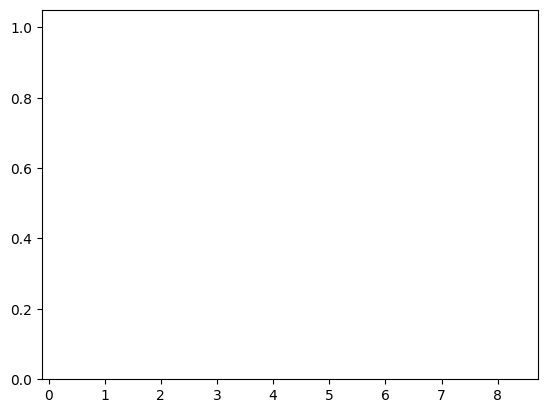

In [232]:
_ = plt.hist(energy, bins=100)

In [150]:
def plot_latent_space(forward_model, params, sigma=1.):
    z_new = jax.random.normal(rng_key, shape=(5000, n_spatial_dim))*sigma
    x_new, _ = forward_model.apply(params, z_new)
    _ = plt.hist(efun(x_new), bins=100)
    
    #print(efun(x_new)[0:10])
    

In [245]:
traj = jax.random.shuffle(rng_key, traj)
training_PCA = PCA(whiten=True).fit(traj)
training_data = training_PCA.transform(traj).reshape((10, 5000, 9))

def training_PCA_inverse_transform(X):
    model = training_PCA
    return jnp.dot(
        X, jnp.sqrt(model.explained_variance_[:, jnp.newaxis]) * model.components_,
    ) + model.mean_

def efun(batch):
    
    @jax.vmap
    def efun_inner(conf):
        conf = conf.reshape((n_particles, 3))
        conf = conf + test_cg_ref_meta1 # broadcast, align last two dims
        return test_cg_efun.apply(test_cg_efun_params, conf)
    
    batch = training_PCA_inverse_transform(batch)
    batch = unanchor(batch)
    return efun_inner(batch)


/Users/ziyuanzhao/miniforge3/envs/jax/lib/python3.10/site-packages/jax/_src/random.py:399: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


In [250]:
rng_key = jax.random.PRNGKey(41)
initial_sigma = 1e-3
batch_size = 5000

#trans_vec, rot_mat, meta1_anchored = anchor((test_cg_ref_meta1 - test_cg_ref).reshape((1, 15)))

# diff_anchored = (test_cg_ref_meta1 - test_cg_ref).reshape((15,))[6:]
random_training_data = jax.random.normal(rng_key, shape=(10, batch_size, n_spatial_dim))*initial_sigma

Epoch 0, loss: 12.74882984161377


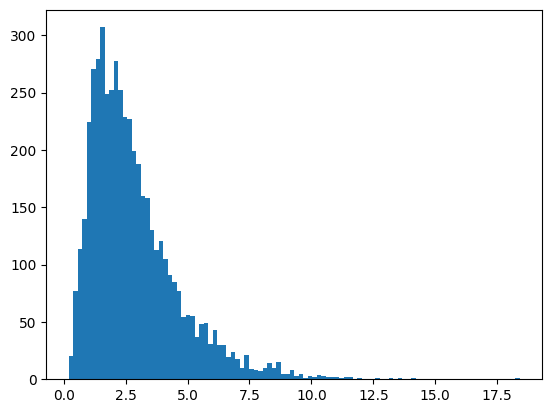

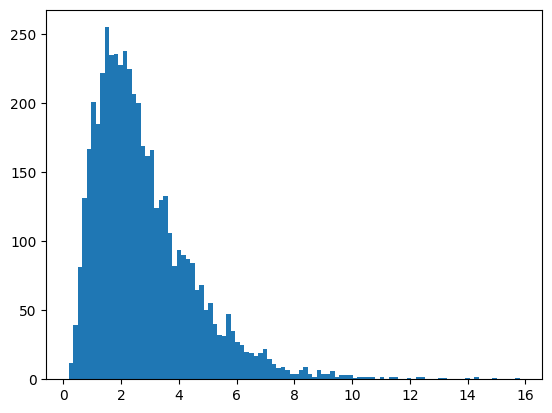

Epoch 1, loss: 12.748741149902344
Epoch 2, loss: 12.748627662658691
Epoch 3, loss: 12.748527526855469
Epoch 4, loss: 12.748444557189941
Epoch 5, loss: 12.748374938964844
Epoch 6, loss: 12.748313903808594
Epoch 7, loss: 12.748259544372559
Epoch 8, loss: 12.748208045959473
Epoch 9, loss: 12.748159408569336
Epoch 10, loss: 12.748116493225098


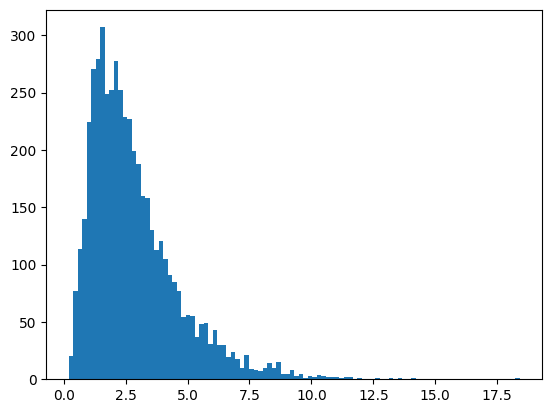

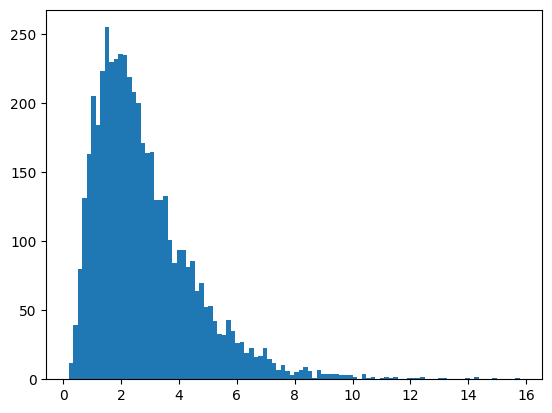

Epoch 11, loss: 12.74807357788086
Epoch 12, loss: 12.748034477233887
Epoch 13, loss: 12.747998237609863
Epoch 14, loss: 12.747963905334473
Epoch 15, loss: 12.747929573059082
Epoch 16, loss: 12.747899055480957
Epoch 17, loss: 12.7478666305542
Epoch 18, loss: 12.747836112976074
Epoch 19, loss: 12.747808456420898
Epoch 20, loss: 12.74777889251709


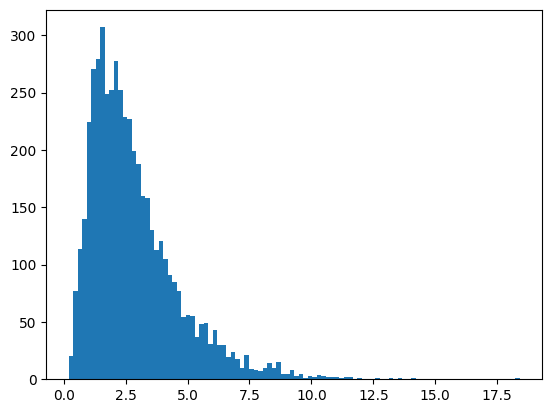

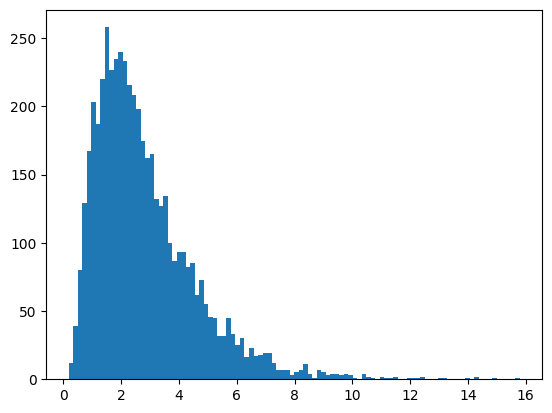

Epoch 21, loss: 12.747751235961914
Epoch 22, loss: 12.747724533081055
Epoch 23, loss: 12.747699737548828
Epoch 24, loss: 12.747673034667969
Epoch 25, loss: 12.747648239135742
Epoch 26, loss: 12.7476224899292
Epoch 27, loss: 12.747598648071289
Epoch 28, loss: 12.747572898864746
Epoch 29, loss: 12.74754810333252
Epoch 30, loss: 12.74752426147461


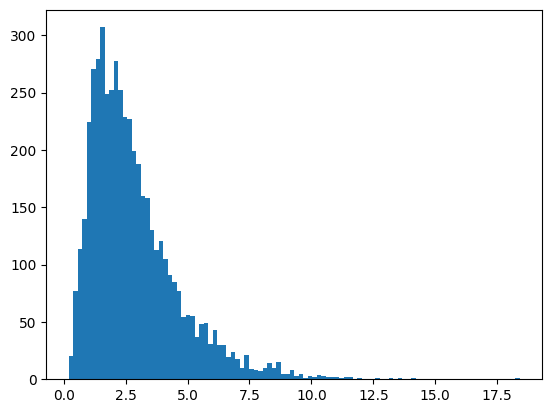

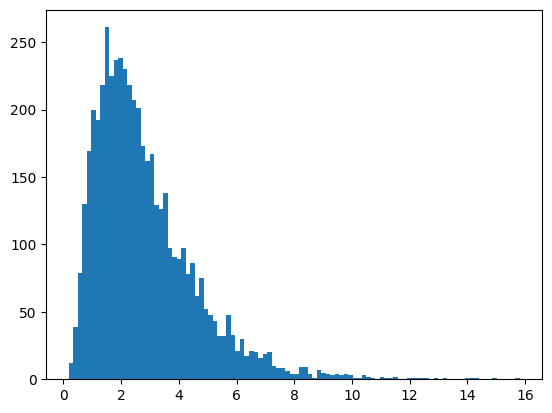

Epoch 31, loss: 12.7475004196167
Epoch 32, loss: 12.747478485107422
Epoch 33, loss: 12.747455596923828
Epoch 34, loss: 12.747432708740234
Epoch 35, loss: 12.747411727905273
Epoch 36, loss: 12.74738883972168
Epoch 37, loss: 12.747368812561035
Epoch 38, loss: 12.747346878051758
Epoch 39, loss: 12.747325897216797
Epoch 40, loss: 12.747304916381836


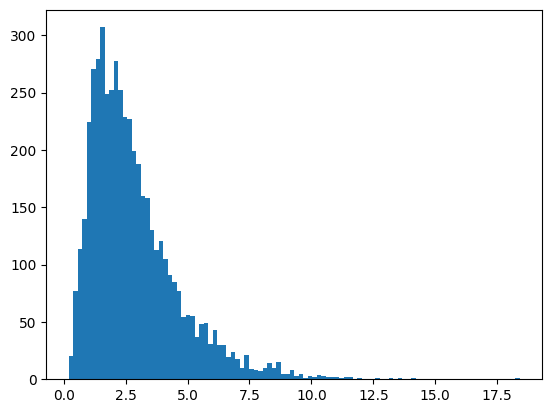

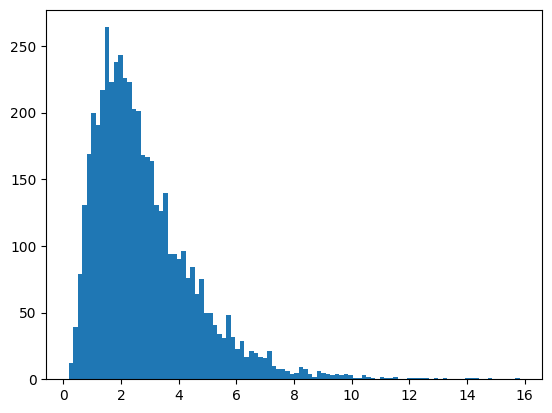

Epoch 41, loss: 12.747284889221191
Epoch 42, loss: 12.74726390838623
Epoch 43, loss: 12.747243881225586
Epoch 44, loss: 12.747224807739258
Epoch 45, loss: 12.747204780578613
Epoch 46, loss: 12.747184753417969
Epoch 47, loss: 12.74716567993164
Epoch 48, loss: 12.747146606445312
Epoch 49, loss: 12.747129440307617
Epoch 0, loss: 126.80429077148438


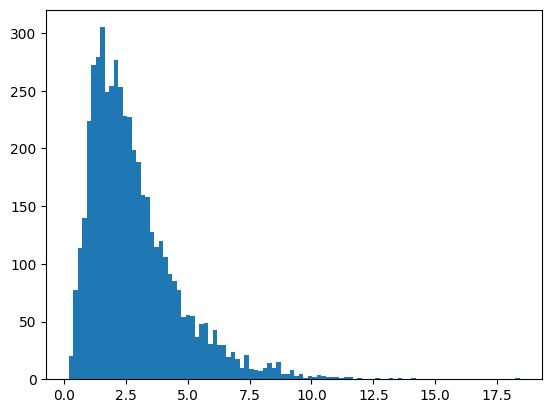

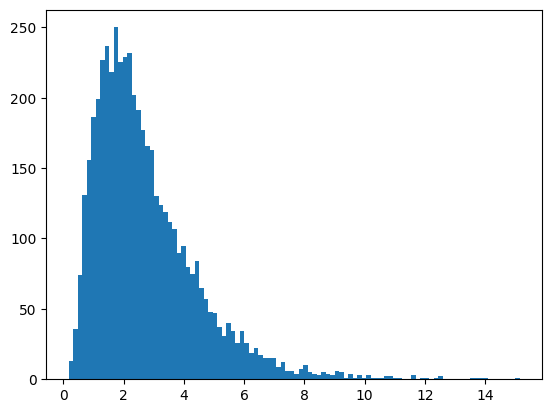

Epoch 1, loss: 117.79902648925781
Epoch 2, loss: 109.5491714477539
Epoch 3, loss: 102.26215362548828
Epoch 4, loss: 95.78001403808594
Epoch 5, loss: 89.87184143066406
Epoch 6, loss: 84.36305236816406
Epoch 7, loss: 79.16987609863281
Epoch 8, loss: 74.2761459350586
Epoch 9, loss: 69.70929718017578
Epoch 10, loss: 65.50676727294922
Epoch 11, loss: 61.69959259033203
Epoch 12, loss: 58.31179428100586
Epoch 13, loss: 55.346885681152344
Epoch 14, loss: 52.79390335083008
Epoch 15, loss: 50.624881744384766
Epoch 16, loss: 48.80244445800781
Epoch 17, loss: 47.28208923339844
Epoch 18, loss: 46.01784896850586
Epoch 19, loss: 44.96563720703125
Epoch 20, loss: 44.08066177368164
Epoch 21, loss: 43.32807922363281
Epoch 22, loss: 42.67700958251953
Epoch 23, loss: 42.10428237915039
Epoch 24, loss: 41.58872604370117
Epoch 25, loss: 41.115806579589844
Epoch 26, loss: 40.675018310546875
Epoch 27, loss: 40.2625617980957
Epoch 28, loss: 39.87200164794922
Epoch 29, loss: 39.494972229003906
Epoch 30, loss: 39

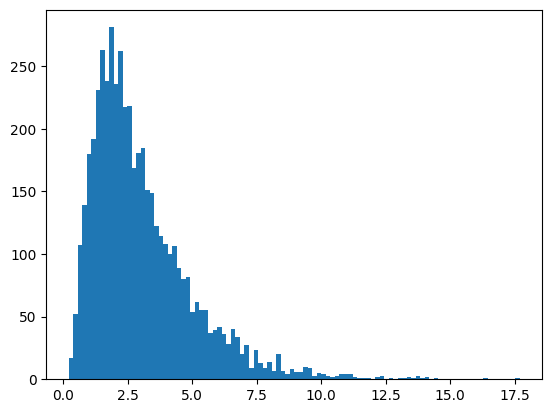

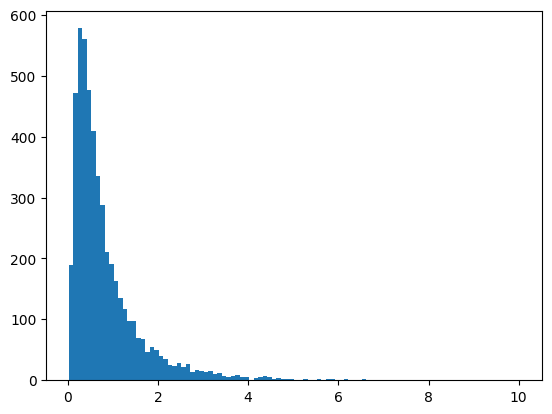

Epoch 51, loss: 34.330596923828125
Epoch 52, loss: 34.24620819091797
Epoch 53, loss: 34.165157318115234
Epoch 54, loss: 34.094844818115234
Epoch 55, loss: 34.02622604370117
Epoch 56, loss: 33.961769104003906
Epoch 57, loss: 33.91158676147461
Epoch 58, loss: 33.86132049560547
Epoch 59, loss: 33.816673278808594
Epoch 60, loss: 33.77067184448242
Epoch 61, loss: 33.730777740478516
Epoch 62, loss: 33.68733215332031
Epoch 63, loss: 33.65241241455078
Epoch 64, loss: 33.61778259277344
Epoch 65, loss: 33.584556579589844
Epoch 66, loss: 33.552364349365234
Epoch 67, loss: 33.525306701660156
Epoch 68, loss: 33.4975700378418
Epoch 69, loss: 33.47144317626953
Epoch 70, loss: 33.44892883300781
Epoch 71, loss: 33.425777435302734
Epoch 72, loss: 33.39948272705078
Epoch 73, loss: 33.37998580932617
Epoch 74, loss: 33.35663986206055
Epoch 75, loss: 33.33172607421875
Epoch 76, loss: 33.31656265258789
Epoch 77, loss: 33.29703140258789
Epoch 78, loss: 33.27566909790039
Epoch 79, loss: 33.25676727294922
Epoch

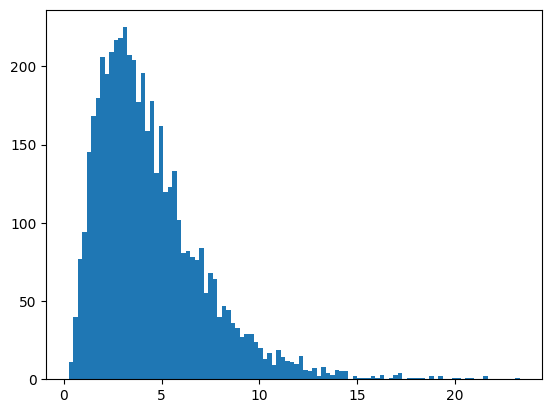

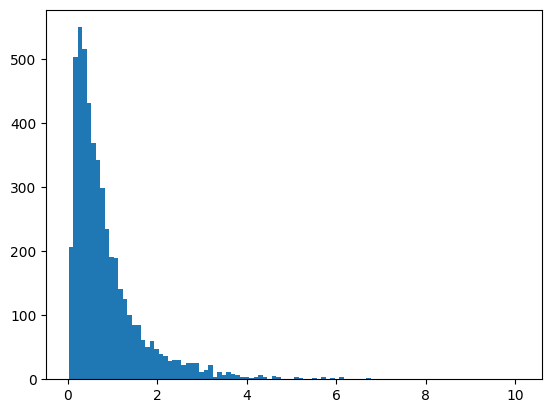

Epoch 101, loss: 33.1357421875
Epoch 102, loss: 33.13487243652344
Epoch 103, loss: 33.13841247558594
Epoch 104, loss: 33.13645935058594
Epoch 105, loss: 33.138702392578125
Epoch 106, loss: 33.13772964477539
Epoch 107, loss: 33.142337799072266
Epoch 108, loss: 33.149173736572266
Epoch 109, loss: 33.15680694580078
Epoch 110, loss: 33.148250579833984
Epoch 111, loss: 33.16554260253906
Epoch 112, loss: 33.177249908447266
Epoch 113, loss: 33.183189392089844
Epoch 114, loss: 33.192989349365234
Epoch 115, loss: 33.206417083740234
Epoch 116, loss: 33.212276458740234
Epoch 117, loss: 33.22410583496094
Epoch 118, loss: 33.237648010253906
Epoch 119, loss: 33.25507354736328
Epoch 120, loss: 33.25545120239258
Epoch 121, loss: 33.2620964050293
Epoch 122, loss: 33.272972106933594
Epoch 123, loss: 33.28293991088867
Epoch 124, loss: 33.29526138305664
Epoch 125, loss: 33.312496185302734
Epoch 126, loss: 33.32735824584961
Epoch 127, loss: 33.33447265625
Epoch 128, loss: 33.350860595703125
Epoch 129, loss

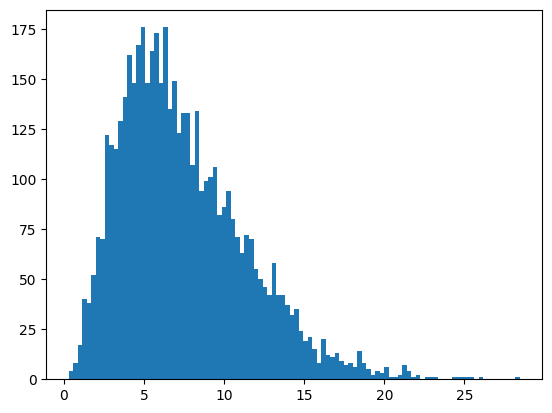

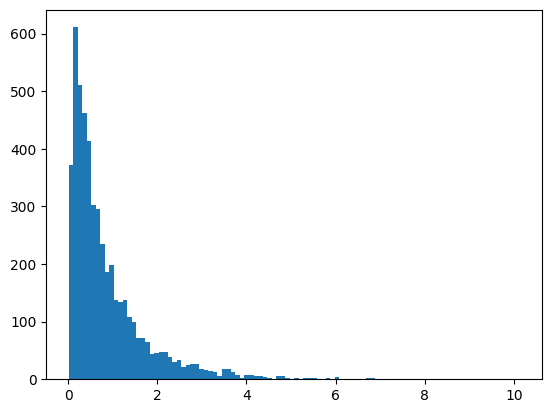

Epoch 151, loss: 33.78657531738281
Epoch 152, loss: 33.81009292602539
Epoch 153, loss: 33.830169677734375
Epoch 154, loss: 33.87123489379883
Epoch 155, loss: 33.914363861083984
Epoch 156, loss: 33.94228744506836
Epoch 157, loss: 33.95475769042969
Epoch 158, loss: 33.960060119628906
Epoch 159, loss: 33.974002838134766
Epoch 160, loss: 33.98102951049805
Epoch 161, loss: 33.9799919128418
Epoch 162, loss: 33.99897384643555
Epoch 163, loss: 34.01486587524414
Epoch 164, loss: 34.03090286254883
Epoch 165, loss: 34.07172775268555
Epoch 166, loss: 34.06535339355469
Epoch 167, loss: 34.071292877197266
Epoch 168, loss: 34.05984878540039
Epoch 169, loss: 34.07887268066406
Epoch 170, loss: 34.08366012573242
Epoch 171, loss: 34.083404541015625
Epoch 172, loss: 34.103736877441406
Epoch 173, loss: 34.091346740722656
Epoch 174, loss: 34.081539154052734
Epoch 175, loss: 34.101951599121094
Epoch 176, loss: 34.1187858581543
Epoch 177, loss: 34.11605453491211
Epoch 178, loss: 34.113006591796875
Epoch 179, 

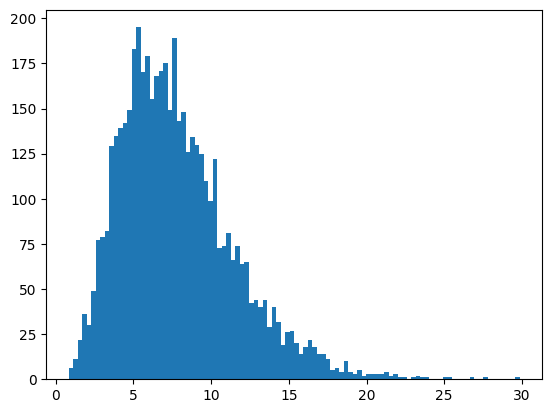

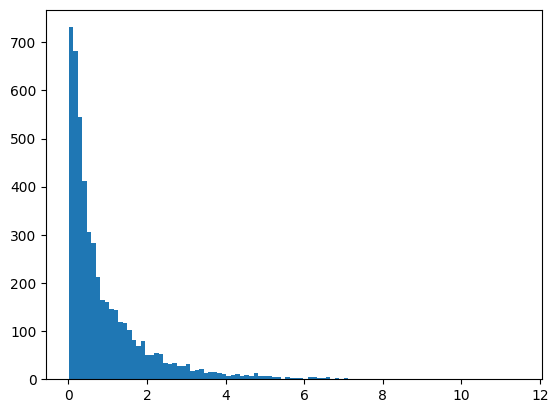

Epoch 201, loss: 33.97498321533203
Epoch 202, loss: 33.969215393066406
Epoch 203, loss: 33.94926834106445
Epoch 204, loss: 33.94321060180664
Epoch 205, loss: 33.92820739746094
Epoch 206, loss: 33.92873001098633
Epoch 207, loss: 33.92067337036133
Epoch 208, loss: 33.91267776489258
Epoch 209, loss: 33.897666931152344
Epoch 210, loss: 33.90431594848633
Epoch 211, loss: 33.91522216796875
Epoch 212, loss: 33.90864944458008
Epoch 213, loss: 33.89617919921875
Epoch 214, loss: 33.89407730102539
Epoch 215, loss: 33.89604187011719
Epoch 216, loss: 33.89774703979492
Epoch 217, loss: 33.89495849609375
Epoch 218, loss: 33.88653564453125
Epoch 219, loss: 33.888423919677734
Epoch 220, loss: 33.8884391784668
Epoch 221, loss: 33.88302230834961
Epoch 222, loss: 33.881168365478516
Epoch 223, loss: 33.89146041870117
Epoch 224, loss: 33.89081573486328
Epoch 225, loss: 33.903533935546875
Epoch 226, loss: 33.905113220214844
Epoch 227, loss: 33.90980911254883
Epoch 228, loss: 33.91288757324219
Epoch 229, loss

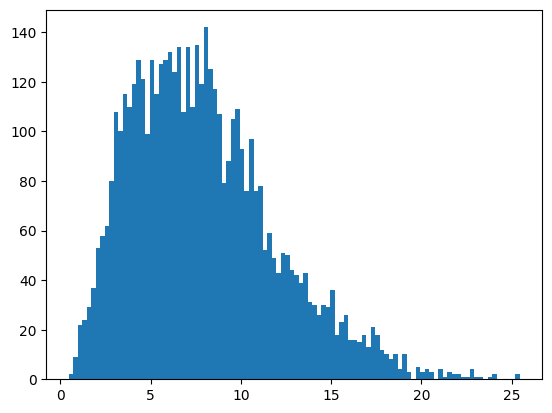

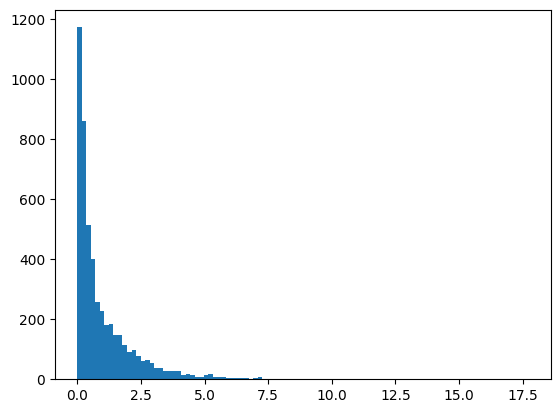

Epoch 251, loss: 34.06885528564453
Epoch 252, loss: 34.07419967651367
Epoch 253, loss: 34.08826446533203
Epoch 254, loss: 34.094390869140625
Epoch 255, loss: 34.1086311340332
Epoch 256, loss: 34.115570068359375
Epoch 257, loss: 34.14426803588867
Epoch 258, loss: 34.155921936035156
Epoch 259, loss: 34.16238784790039
Epoch 260, loss: 34.18271255493164
Epoch 261, loss: 34.19749069213867
Epoch 262, loss: 34.21685028076172
Epoch 263, loss: 34.2396125793457
Epoch 264, loss: 34.25456619262695
Epoch 265, loss: 34.27622985839844
Epoch 266, loss: 34.29372787475586
Epoch 267, loss: 34.30181884765625
Epoch 268, loss: 34.32026672363281
Epoch 269, loss: 34.335838317871094
Epoch 270, loss: 34.34552764892578
Epoch 271, loss: 34.378299713134766
Epoch 272, loss: 34.3930549621582
Epoch 273, loss: 34.41926956176758
Epoch 274, loss: 34.44054412841797
Epoch 275, loss: 34.45307922363281
Epoch 276, loss: 34.47953414916992
Epoch 277, loss: 34.489864349365234
Epoch 278, loss: 34.52012634277344
Epoch 279, loss: 

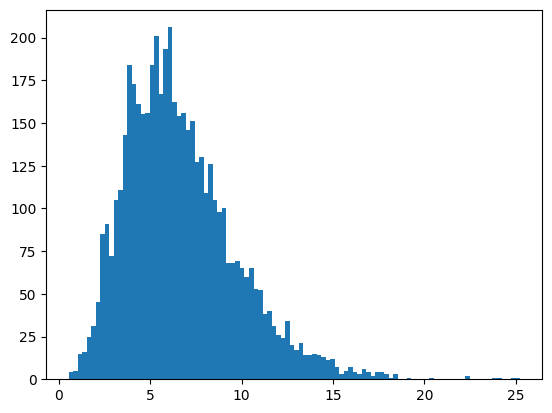

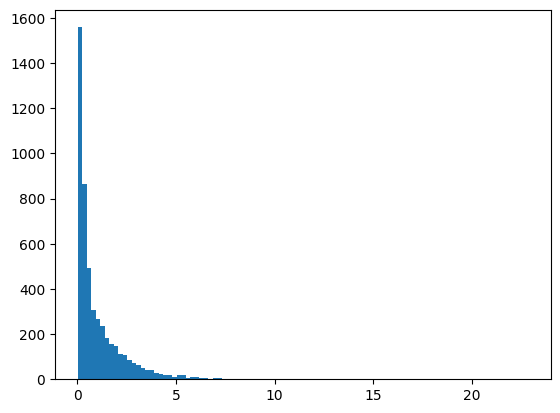

Epoch 301, loss: 34.97844696044922
Epoch 302, loss: 35.001399993896484
Epoch 303, loss: 35.02146530151367
Epoch 304, loss: 35.05093765258789
Epoch 305, loss: 35.070762634277344
Epoch 306, loss: 35.09688949584961
Epoch 307, loss: 35.122413635253906
Epoch 308, loss: 35.14247512817383
Epoch 309, loss: 35.16580581665039
Epoch 310, loss: 35.1878776550293
Epoch 311, loss: 35.21002960205078
Epoch 312, loss: 35.22498321533203
Epoch 313, loss: 35.25143814086914
Epoch 314, loss: 35.28150177001953
Epoch 315, loss: 35.308509826660156
Epoch 316, loss: 35.33899688720703
Epoch 317, loss: 35.364498138427734
Epoch 318, loss: 35.378990173339844
Epoch 319, loss: 35.40854263305664
Epoch 320, loss: 35.42762756347656
Epoch 321, loss: 35.458892822265625
Epoch 322, loss: 35.4943962097168
Epoch 323, loss: 35.525611877441406
Epoch 324, loss: 35.55229187011719
Epoch 325, loss: 35.56675720214844
Epoch 326, loss: 35.59577560424805
Epoch 327, loss: 35.61809158325195
Epoch 328, loss: 35.638126373291016
Epoch 329, lo

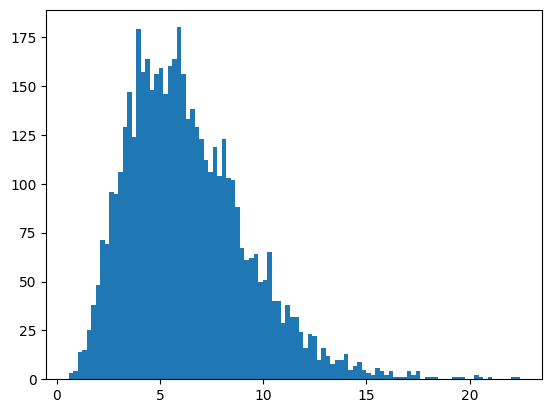

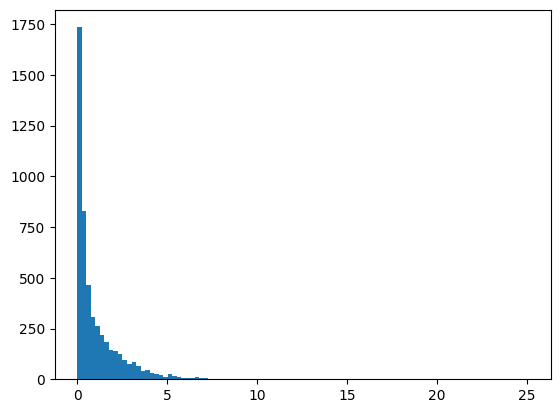

Epoch 351, loss: 36.24652099609375
Epoch 352, loss: 36.27814483642578
Epoch 353, loss: 36.29965591430664
Epoch 354, loss: 36.331233978271484
Epoch 355, loss: 36.35592269897461
Epoch 356, loss: 36.36674499511719
Epoch 357, loss: 36.39897918701172
Epoch 358, loss: 36.4340705871582
Epoch 359, loss: 36.46649169921875
Epoch 360, loss: 36.49591064453125
Epoch 361, loss: 36.52778244018555
Epoch 362, loss: 36.558956146240234
Epoch 363, loss: 36.585628509521484
Epoch 364, loss: 36.598331451416016
Epoch 365, loss: 36.62583923339844
Epoch 366, loss: 36.660648345947266
Epoch 367, loss: 36.68617630004883
Epoch 368, loss: 36.72215270996094
Epoch 369, loss: 36.75602340698242
Epoch 370, loss: 36.79354476928711
Epoch 371, loss: 36.822845458984375
Epoch 372, loss: 36.85934829711914
Epoch 373, loss: 36.886138916015625
Epoch 374, loss: 36.911800384521484
Epoch 375, loss: 36.94210433959961
Epoch 376, loss: 36.97404479980469
Epoch 377, loss: 36.99490737915039
Epoch 378, loss: 37.01994323730469
Epoch 379, lo

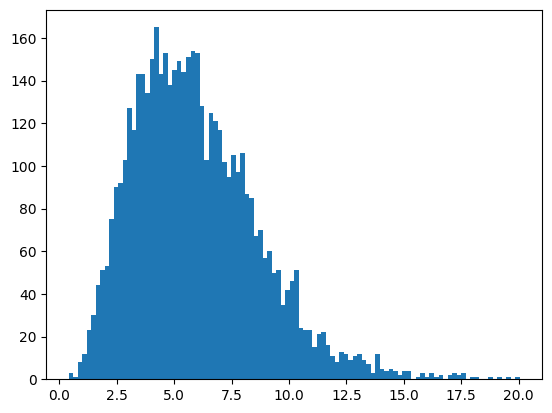

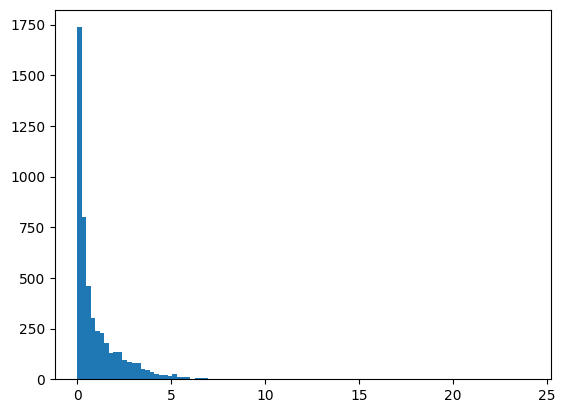

Epoch 401, loss: 37.76640319824219
Epoch 402, loss: 37.802425384521484
Epoch 403, loss: 37.84060287475586
Epoch 404, loss: 37.873687744140625
Epoch 405, loss: 37.902137756347656
Epoch 406, loss: 37.93234634399414
Epoch 407, loss: 37.954734802246094
Epoch 408, loss: 37.9805908203125
Epoch 409, loss: 38.01487731933594
Epoch 410, loss: 38.044620513916016
Epoch 411, loss: 38.079864501953125
Epoch 412, loss: 38.12055969238281
Epoch 413, loss: 38.153892517089844
Epoch 414, loss: 38.19021987915039
Epoch 415, loss: 38.226593017578125
Epoch 416, loss: 38.2570686340332
Epoch 417, loss: 38.28798294067383
Epoch 418, loss: 38.32048797607422
Epoch 419, loss: 38.35723876953125
Epoch 420, loss: 38.390865325927734
Epoch 421, loss: 38.43073654174805
Epoch 422, loss: 38.46113204956055
Epoch 423, loss: 38.49100112915039
Epoch 424, loss: 38.52558517456055
Epoch 425, loss: 38.56372833251953
Epoch 426, loss: 38.597991943359375
Epoch 427, loss: 38.632511138916016
Epoch 428, loss: 38.66840362548828
Epoch 429, 

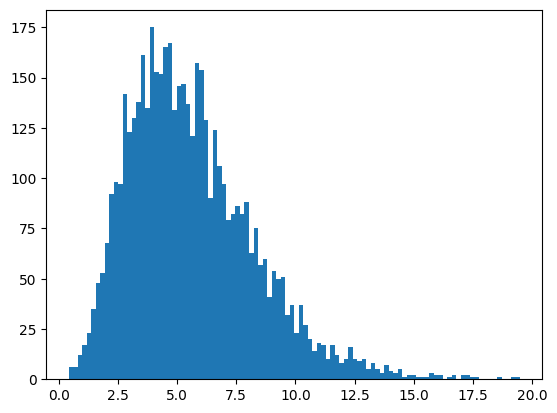

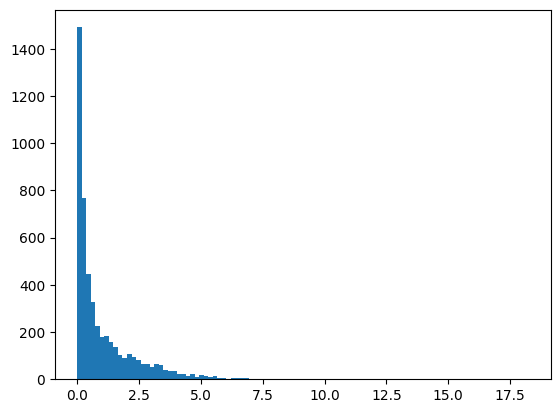

Epoch 451, loss: 39.494808197021484
Epoch 452, loss: 39.53535842895508
Epoch 453, loss: 39.57594299316406
Epoch 454, loss: 39.6182861328125
Epoch 455, loss: 39.65676498413086
Epoch 456, loss: 39.691062927246094
Epoch 457, loss: 39.724308013916016
Epoch 458, loss: 39.76353073120117
Epoch 459, loss: 39.79966354370117
Epoch 460, loss: 39.8396110534668
Epoch 461, loss: 39.878543853759766
Epoch 462, loss: 39.91918182373047
Epoch 463, loss: 39.961185455322266
Epoch 464, loss: 40.00138854980469
Epoch 465, loss: 40.04095458984375
Epoch 466, loss: 40.08190155029297
Epoch 467, loss: 40.11570358276367
Epoch 468, loss: 40.15643310546875
Epoch 469, loss: 40.19544219970703
Epoch 470, loss: 40.231773376464844
Epoch 471, loss: 40.27098083496094
Epoch 472, loss: 40.312950134277344
Epoch 473, loss: 40.33583450317383
Epoch 474, loss: 40.37886428833008
Epoch 475, loss: 40.421043395996094
Epoch 476, loss: 40.46025848388672
Epoch 477, loss: 40.499542236328125
Epoch 478, loss: 40.53553009033203
Epoch 479, lo

In [260]:
from copy import deepcopy
import optax

# rng_key = jax.random.PRNGKey(41)
# initial_sigma = 1e-3
# batch_size = 1000

#training_data = jax.random.normal(rng_key, shape=(10, batch_size, n_spatial_dim))*initial_sigma + (test_cg_ref_meta1 - test_cg_ref).reshape((n_spatial_dim, ))

params = reverse_model.init(rng_key, batch=jnp.ones([batch_size, n_spatial_dim]))
training_data_copy = jnp.array(training_data) 
optimizer = optax.adam(learning_rate=1e-4)
params, training_data_copy = adaptive_fit(params, optimizer, 500, training_data_copy,
                                          rng_key=rng_key, efun=efun,
                                          sigma_range=[1e-4, 1], log_beta_range=[-0.5, 0],
                                          warm_up_epochs=50)


Epoch 0, loss: 41.40482711791992


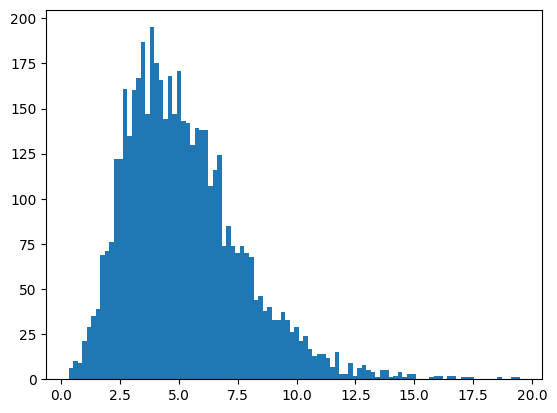

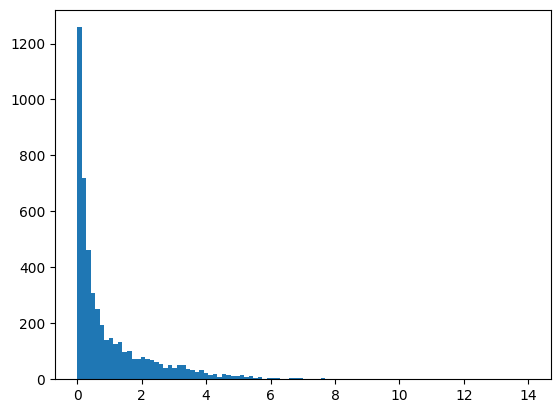

Epoch 1, loss: 41.39476776123047
Epoch 2, loss: 41.39208221435547
Epoch 3, loss: 41.38565444946289
Epoch 4, loss: 41.3781852722168
Epoch 5, loss: 41.37428665161133
Epoch 6, loss: 41.36773681640625
Epoch 7, loss: 41.36076736450195
Epoch 8, loss: 41.355224609375
Epoch 9, loss: 41.35139465332031
Epoch 10, loss: 41.34686279296875
Epoch 11, loss: 41.33967590332031
Epoch 12, loss: 41.32940673828125
Epoch 13, loss: 41.323448181152344
Epoch 14, loss: 41.320621490478516
Epoch 15, loss: 41.310420989990234
Epoch 16, loss: 41.30813217163086
Epoch 17, loss: 41.3041877746582
Epoch 18, loss: 41.29886245727539
Epoch 19, loss: 41.294960021972656
Epoch 20, loss: 41.291866302490234
Epoch 21, loss: 41.28871536254883
Epoch 22, loss: 41.27948760986328
Epoch 23, loss: 41.27302551269531
Epoch 24, loss: 41.27073669433594
Epoch 25, loss: 41.26441955566406
Epoch 26, loss: 41.26018524169922
Epoch 27, loss: 41.25923156738281
Epoch 28, loss: 41.25661849975586
Epoch 29, loss: 41.250160217285156
Epoch 30, loss: 41.24

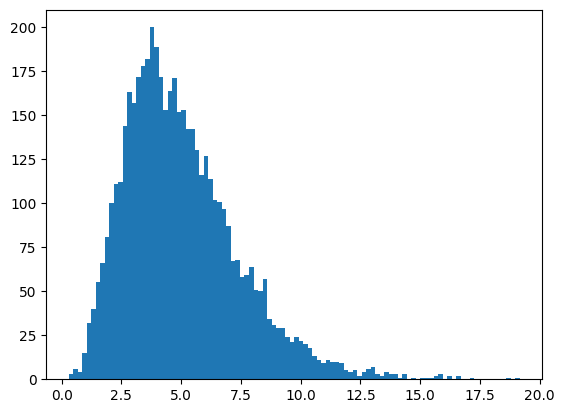

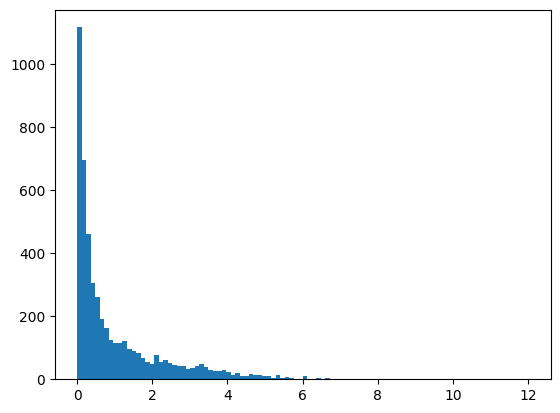

Epoch 51, loss: 41.161827087402344
Epoch 52, loss: 41.152374267578125
Epoch 53, loss: 41.1475830078125
Epoch 54, loss: 41.14283752441406
Epoch 55, loss: 41.138404846191406
Epoch 56, loss: 41.13306427001953
Epoch 57, loss: 41.1293830871582
Epoch 58, loss: 41.130699157714844
Epoch 59, loss: 41.12981414794922
Epoch 60, loss: 41.12394714355469
Epoch 61, loss: 41.12626266479492
Epoch 62, loss: 41.12378692626953
Epoch 63, loss: 41.11628341674805
Epoch 64, loss: 41.111549377441406
Epoch 65, loss: 41.1114387512207
Epoch 66, loss: 41.10917282104492
Epoch 67, loss: 41.1060791015625
Epoch 68, loss: 41.10221481323242
Epoch 69, loss: 41.10282897949219
Epoch 70, loss: 41.10258865356445
Epoch 71, loss: 41.100074768066406
Epoch 72, loss: 41.0958137512207
Epoch 73, loss: 41.09144973754883
Epoch 74, loss: 41.086708068847656
Epoch 75, loss: 41.08026123046875
Epoch 76, loss: 41.07887268066406
Epoch 77, loss: 41.077308654785156
Epoch 78, loss: 41.075225830078125
Epoch 79, loss: 41.07205581665039
Epoch 80, 

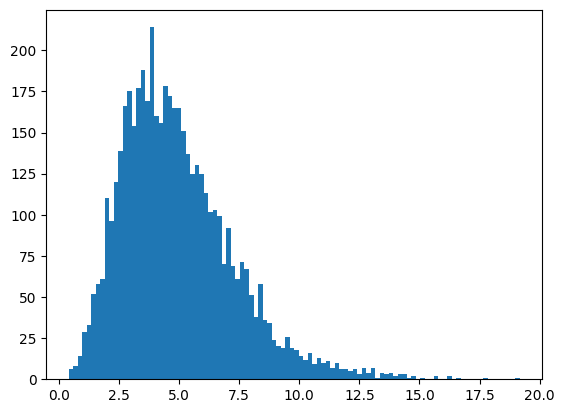

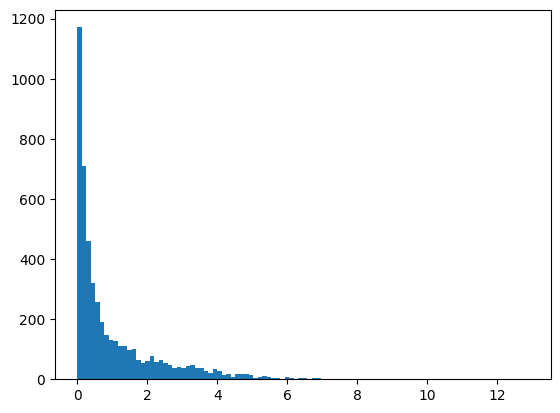

Epoch 101, loss: 40.99700164794922
Epoch 102, loss: 40.993377685546875
Epoch 103, loss: 40.9902458190918
Epoch 104, loss: 40.98588562011719
Epoch 105, loss: 40.983734130859375
Epoch 106, loss: 40.98067855834961
Epoch 107, loss: 40.979103088378906
Epoch 108, loss: 40.978050231933594
Epoch 109, loss: 40.97990417480469
Epoch 110, loss: 40.980403900146484
Epoch 111, loss: 40.9821662902832
Epoch 112, loss: 40.984474182128906
Epoch 113, loss: 40.98286437988281
Epoch 114, loss: 40.979705810546875
Epoch 115, loss: 40.980892181396484
Epoch 116, loss: 40.98103713989258
Epoch 117, loss: 40.97866439819336
Epoch 118, loss: 40.97771072387695
Epoch 119, loss: 40.97526168823242
Epoch 120, loss: 40.972835540771484
Epoch 121, loss: 40.96887969970703
Epoch 122, loss: 40.94753646850586
Epoch 123, loss: 40.95091247558594
Epoch 124, loss: 40.95556640625
Epoch 125, loss: 40.95433807373047
Epoch 126, loss: 40.95083236694336
Epoch 127, loss: 40.952938079833984
Epoch 128, loss: 40.95307159423828
Epoch 129, loss

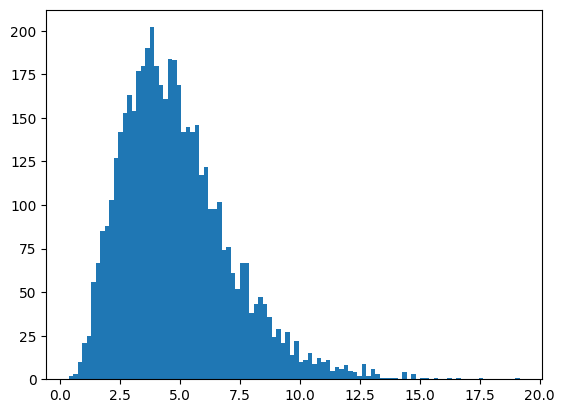

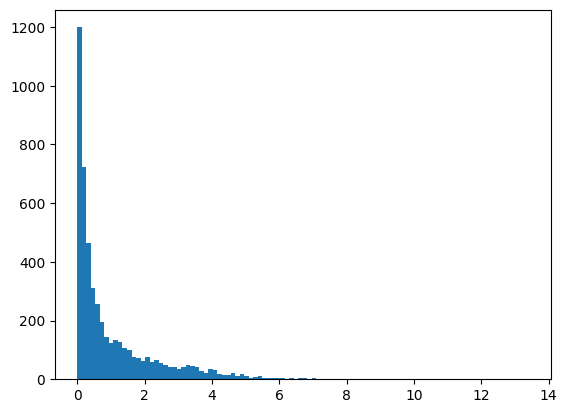

Epoch 151, loss: 40.88607406616211
Epoch 152, loss: 40.89152145385742
Epoch 153, loss: 40.897098541259766
Epoch 154, loss: 40.89706802368164
Epoch 155, loss: 40.89776611328125
Epoch 156, loss: 40.898460388183594
Epoch 157, loss: 40.908721923828125
Epoch 158, loss: 40.91252517700195
Epoch 159, loss: 40.91429138183594
Epoch 160, loss: 40.91448211669922
Epoch 161, loss: 40.91190719604492
Epoch 162, loss: 40.91168975830078
Epoch 163, loss: 40.91433334350586
Epoch 164, loss: 40.91619110107422
Epoch 165, loss: 40.91643142700195
Epoch 166, loss: 40.91501235961914
Epoch 167, loss: 40.91480255126953
Epoch 168, loss: 40.9118766784668
Epoch 169, loss: 40.913658142089844
Epoch 170, loss: 40.910614013671875
Epoch 171, loss: 40.911537170410156
Epoch 172, loss: 40.91353225708008
Epoch 173, loss: 40.913211822509766
Epoch 174, loss: 40.91343688964844
Epoch 175, loss: 40.91178512573242
Epoch 176, loss: 40.90699768066406
Epoch 177, loss: 40.90681838989258
Epoch 178, loss: 40.900821685791016
Epoch 179, lo

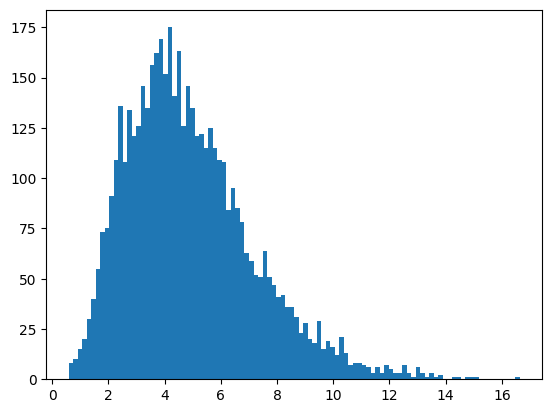

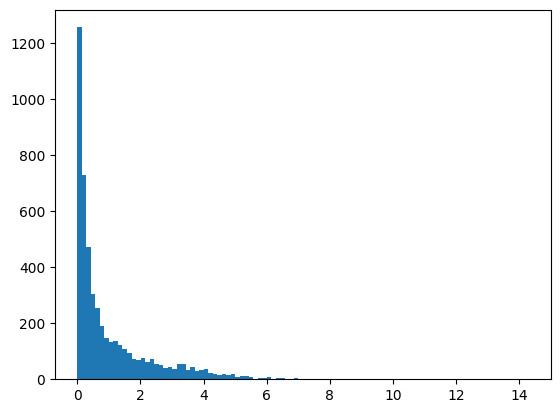

Epoch 201, loss: 40.89085006713867
Epoch 202, loss: 40.88584518432617
Epoch 203, loss: 40.88315963745117
Epoch 204, loss: 40.88269805908203
Epoch 205, loss: 40.87930679321289
Epoch 206, loss: 40.87517166137695
Epoch 207, loss: 40.871742248535156
Epoch 208, loss: 40.87112808227539
Epoch 209, loss: 40.86815643310547
Epoch 210, loss: 40.86431121826172
Epoch 211, loss: 40.859615325927734
Epoch 212, loss: 40.859920501708984
Epoch 213, loss: 40.85635757446289
Epoch 214, loss: 40.856414794921875
Epoch 215, loss: 40.854522705078125
Epoch 216, loss: 40.8519287109375
Epoch 217, loss: 40.85295867919922
Epoch 218, loss: 40.84977340698242
Epoch 219, loss: 40.84796905517578
Epoch 220, loss: 40.85115051269531
Epoch 221, loss: 40.84898376464844
Epoch 222, loss: 40.84720993041992
Epoch 223, loss: 40.84648132324219
Epoch 224, loss: 40.84580612182617
Epoch 225, loss: 40.84861755371094
Epoch 226, loss: 40.84724426269531
Epoch 227, loss: 40.84818649291992
Epoch 228, loss: 40.846981048583984
Epoch 229, loss

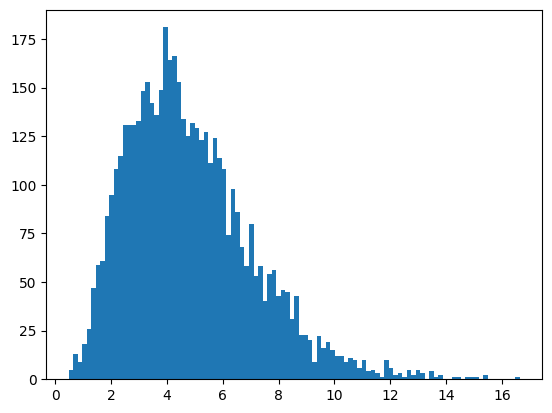

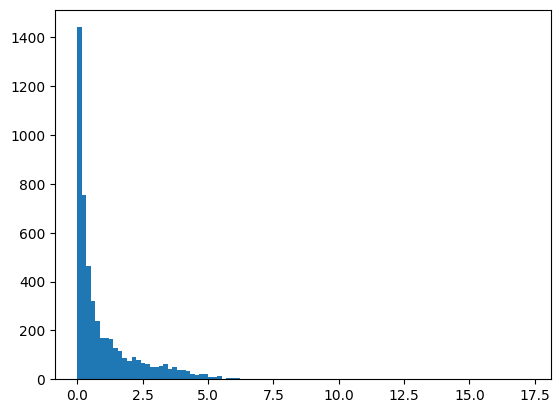

Epoch 251, loss: 40.806640625
Epoch 252, loss: 40.79853820800781
Epoch 253, loss: 40.80128479003906
Epoch 254, loss: 40.8011589050293
Epoch 255, loss: 40.80143737792969
Epoch 256, loss: 40.804725646972656
Epoch 257, loss: 40.80258560180664
Epoch 258, loss: 40.8016357421875
Epoch 259, loss: 40.80510711669922
Epoch 260, loss: 40.805274963378906
Epoch 261, loss: 40.803749084472656
Epoch 262, loss: 40.80067825317383
Epoch 263, loss: 40.799644470214844
Epoch 264, loss: 40.79876708984375
Epoch 265, loss: 40.795047760009766
Epoch 266, loss: 40.79343795776367
Epoch 267, loss: 40.79165267944336
Epoch 268, loss: 40.78937911987305
Epoch 269, loss: 40.78548812866211
Epoch 270, loss: 40.780216217041016
Epoch 271, loss: 40.78144073486328
Epoch 272, loss: 40.77656936645508
Epoch 273, loss: 40.77806854248047
Epoch 274, loss: 40.77499771118164
Epoch 275, loss: 40.774024963378906
Epoch 276, loss: 40.77195358276367
Epoch 277, loss: 40.76795959472656
Epoch 278, loss: 40.764373779296875
Epoch 279, loss: 40

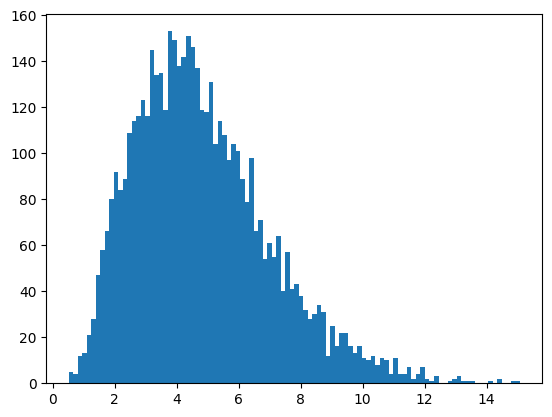

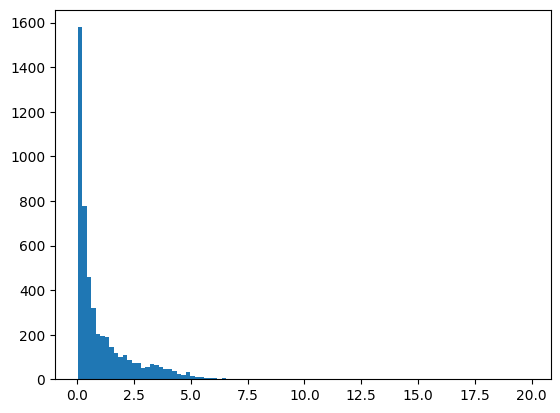

Epoch 301, loss: 40.757904052734375
Epoch 302, loss: 40.758758544921875
Epoch 303, loss: 40.757015228271484
Epoch 304, loss: 40.754268646240234
Epoch 305, loss: 40.752647399902344
Epoch 306, loss: 40.74970626831055
Epoch 307, loss: 40.747337341308594
Epoch 308, loss: 40.74748992919922
Epoch 309, loss: 40.74761199951172
Epoch 310, loss: 40.743709564208984
Epoch 311, loss: 40.73964309692383
Epoch 312, loss: 40.7357292175293
Epoch 313, loss: 40.73305892944336
Epoch 314, loss: 40.730628967285156
Epoch 315, loss: 40.72798156738281
Epoch 316, loss: 40.72591018676758
Epoch 317, loss: 40.72869110107422
Epoch 318, loss: 40.72652053833008
Epoch 319, loss: 40.72635269165039
Epoch 320, loss: 40.72410583496094
Epoch 321, loss: 40.72341537475586
Epoch 322, loss: 40.730194091796875
Epoch 323, loss: 40.7307014465332
Epoch 324, loss: 40.729278564453125
Epoch 325, loss: 40.72813034057617
Epoch 326, loss: 40.7287483215332
Epoch 327, loss: 40.72612762451172
Epoch 328, loss: 40.72230911254883
Epoch 329, lo

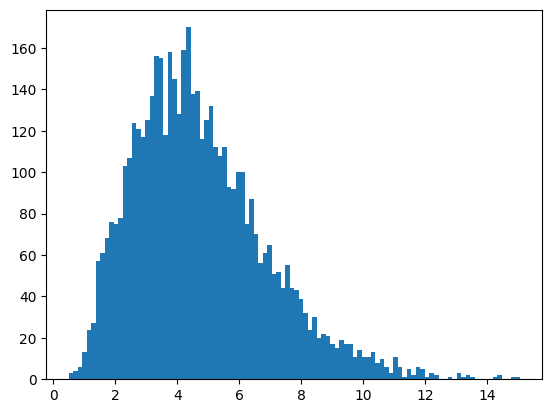

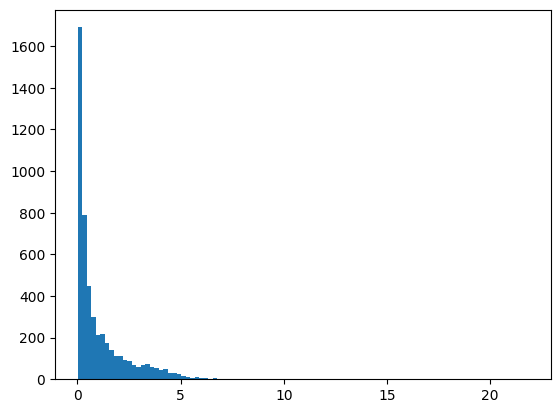

Epoch 351, loss: 40.69483184814453
Epoch 352, loss: 40.693695068359375
Epoch 353, loss: 40.69784164428711
Epoch 354, loss: 40.697242736816406
Epoch 355, loss: 40.69795227050781
Epoch 356, loss: 40.70048141479492
Epoch 357, loss: 40.69780731201172
Epoch 358, loss: 40.69878005981445
Epoch 359, loss: 40.69742202758789
Epoch 360, loss: 40.69632339477539
Epoch 361, loss: 40.69224166870117
Epoch 362, loss: 40.69071960449219
Epoch 363, loss: 40.68931579589844
Epoch 364, loss: 40.690940856933594
Epoch 365, loss: 40.6912841796875
Epoch 366, loss: 40.690391540527344
Epoch 367, loss: 40.68586349487305
Epoch 368, loss: 40.682064056396484
Epoch 369, loss: 40.678829193115234
Epoch 370, loss: 40.67807388305664
Epoch 371, loss: 40.6781005859375
Epoch 372, loss: 40.67608642578125
Epoch 373, loss: 40.669254302978516
Epoch 374, loss: 40.6725959777832
Epoch 375, loss: 40.67000961303711
Epoch 376, loss: 40.669700622558594
Epoch 377, loss: 40.66693878173828
Epoch 378, loss: 40.6715202331543
Epoch 379, loss:

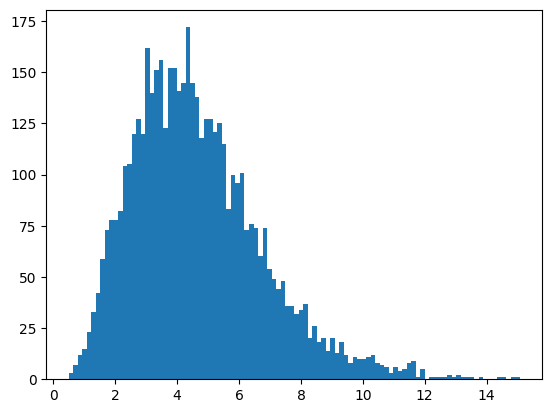

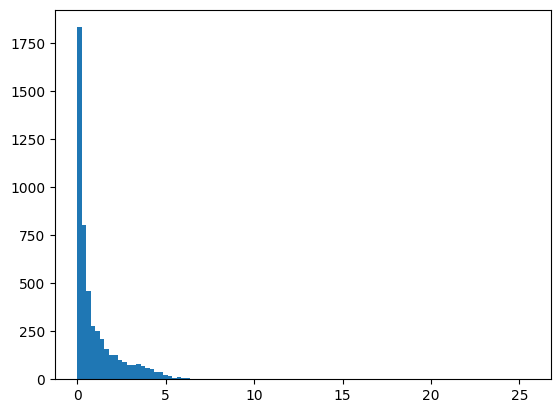

Epoch 401, loss: 40.65619659423828
Epoch 402, loss: 40.65302276611328
Epoch 403, loss: 40.65138244628906
Epoch 404, loss: 40.651344299316406
Epoch 405, loss: 40.65034866333008
Epoch 406, loss: 40.64982223510742
Epoch 407, loss: 40.65256881713867
Epoch 408, loss: 40.651283264160156
Epoch 409, loss: 40.65519332885742
Epoch 410, loss: 40.65287780761719
Epoch 411, loss: 40.654258728027344
Epoch 412, loss: 40.653995513916016
Epoch 413, loss: 40.65302658081055
Epoch 414, loss: 40.650978088378906
Epoch 415, loss: 40.65481185913086
Epoch 416, loss: 40.657169342041016
Epoch 417, loss: 40.65412521362305
Epoch 418, loss: 40.652069091796875
Epoch 419, loss: 40.6524543762207
Epoch 420, loss: 40.64895248413086
Epoch 421, loss: 40.646907806396484
Epoch 422, loss: 40.6484260559082
Epoch 423, loss: 40.64728927612305
Epoch 424, loss: 40.64631652832031
Epoch 425, loss: 40.64450454711914
Epoch 426, loss: 40.64003372192383
Epoch 427, loss: 40.63911056518555
Epoch 428, loss: 40.63731002807617
Epoch 429, los

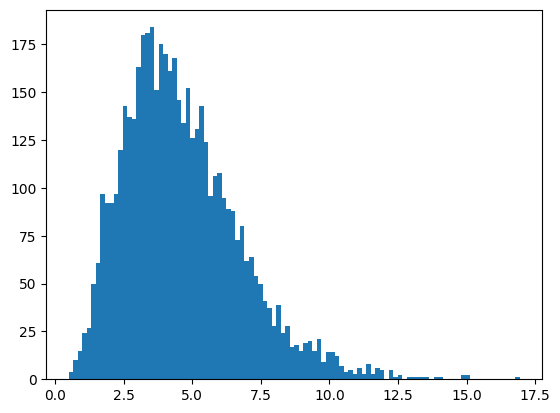

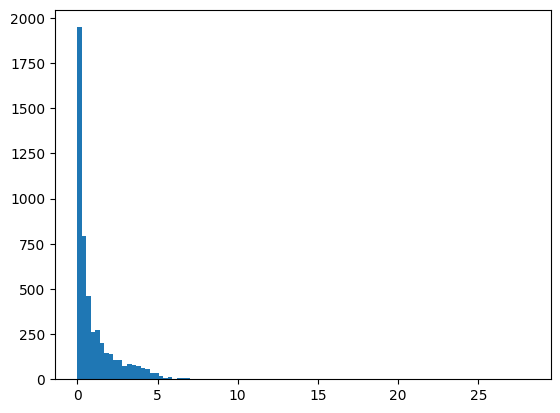

Epoch 451, loss: 40.61672592163086
Epoch 452, loss: 40.61590576171875
Epoch 453, loss: 40.61563491821289
Epoch 454, loss: 40.614051818847656
Epoch 455, loss: 40.61269760131836
Epoch 456, loss: 40.61533737182617
Epoch 457, loss: 40.60930633544922
Epoch 458, loss: 40.60822677612305
Epoch 459, loss: 40.60749816894531
Epoch 460, loss: 40.609500885009766
Epoch 461, loss: 40.60734558105469
Epoch 462, loss: 40.609683990478516
Epoch 463, loss: 40.61023712158203
Epoch 464, loss: 40.61027145385742
Epoch 465, loss: 40.60578536987305
Epoch 466, loss: 40.60358428955078
Epoch 467, loss: 40.60113525390625
Epoch 468, loss: 40.59741973876953
Epoch 469, loss: 40.59426498413086
Epoch 470, loss: 40.59442138671875
Epoch 471, loss: 40.59383010864258
Epoch 472, loss: 40.5922737121582
Epoch 473, loss: 40.58902359008789
Epoch 474, loss: 40.59086227416992
Epoch 475, loss: 40.59260559082031
Epoch 476, loss: 40.59123992919922
Epoch 477, loss: 40.59064865112305
Epoch 478, loss: 40.59115219116211
Epoch 479, loss: 4

In [265]:
params_updated, training_data_copy = adaptive_fit(params, optimizer, 500, training_data_copy,
                                          rng_key=rng_key, efun=efun, 
                                          sigma_range=[1e0, 1e0], log_beta_range=[0, 0],
                                          warm_up_epochs=0)


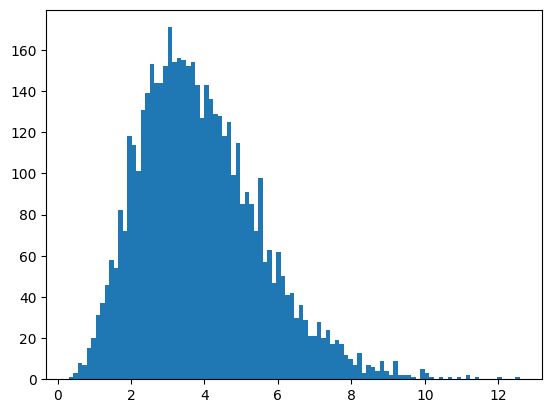

In [41]:
import matplotlib.pyplot as plt

_ = plt.hist(efun(x_test), bins=100)

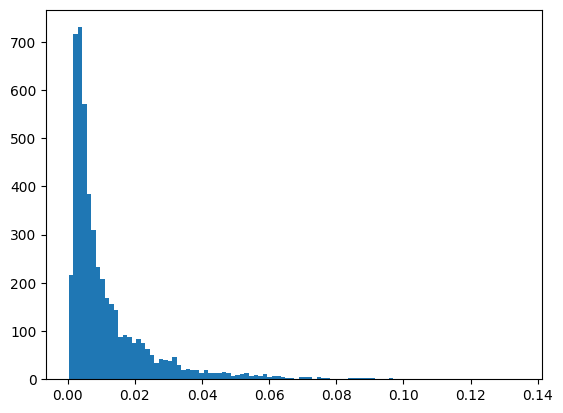

In [268]:
plot_latent_space(forward_model, params, sigma=0.1)

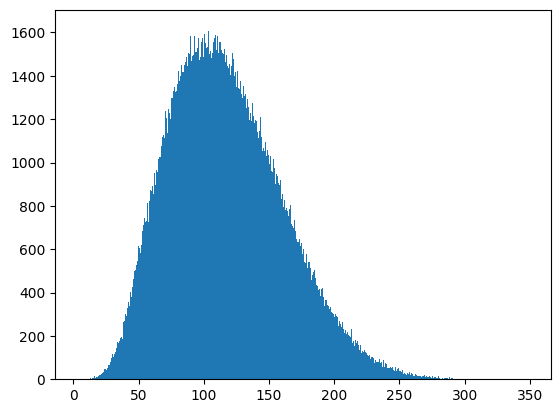

In [48]:
uniform_sample = efun(jax.random.uniform(key=rng_key, shape=(500000, 9)))
result = plt.hist(uniform_sample, bins=1000)
counts, Evals = result[0], result[1]
Evals = (Evals[1:]+Evals[:-1])/2 # take midpoints
exp_weights = np.exp(-Evals)
weighted_counts = counts * exp_weights

Text(0, 0.5, 'Unnormalized Boltzmann density')

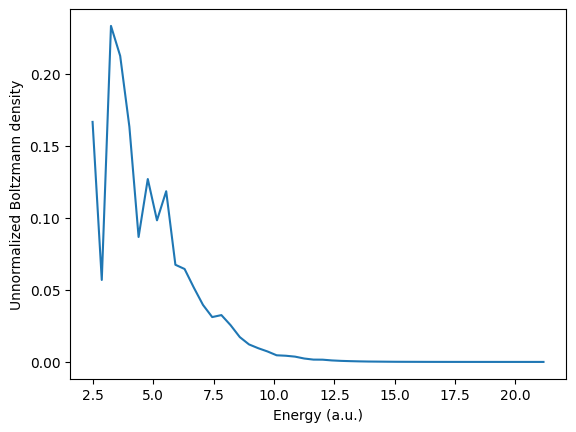

In [53]:
plt.plot(Evals[:50], weighted_counts[:50])
plt.xlabel("Energy (a.u.)")
plt.ylabel("Unnormalized Boltzmann density")

Finally we can evaluate the quality of our samples by looking at distribution of some observables. 

1. distance between v4 and v5.

In [274]:
print(f"Distance at barrier state: {np.linalg.norm(test_cg_ref[3] - test_cg_ref[4]):.2f}")
print(f"Distance at metastable state 1: {np.linalg.norm(test_cg_ref_meta1[3] - test_cg_ref_meta1[4]):.2f}")
print(f"Distance at metastable state 2: {np.linalg.norm(test_cg_ref_meta2[3] - test_cg_ref_meta2[4]):.2f}")

Distance at barrier state: 2.31
Distance at metastate 1: 1.73
Distance at metastate 2: 2.89


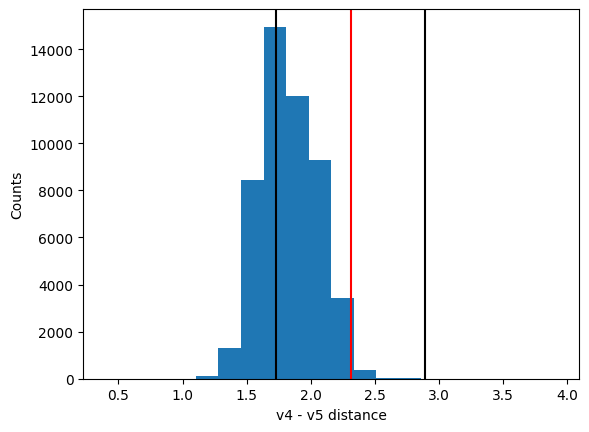

In [303]:
z_new = jax.random.normal(rng_key, shape=(50000, n_spatial_dim))
x_new, _ = forward_model.apply(params, z_new)
x_new_xyz = unanchor(x_new).reshape((-1, 5, 3)) + test_cg_ref_meta1
d45 = jnp.linalg.norm(x_new_xyz[:, 3, :] - x_new_xyz[:, 4, :], axis=1)

plt.hist(d45[d45<4], bins=20)
plt.axvline(1.73, c='k')
plt.axvline(2.31, c='r')
plt.axvline(2.89, c='k')
plt.xlabel('v4 - v5 distance')
_ = plt.ylabel('Counts')


In [294]:
x_new_xyz[1]

DeviceArray([[ 1.        ,  1.        ,  1.        ],
             [-0.9110086 , -1.        ,  1.        ],
             [-0.9679302 ,  1.1986581 , -1.        ],
             [ 0.91825217, -0.7119622 , -1.2705579 ],
             [-0.16124454,  0.10711642,  0.0073146 ]], dtype=float32)

In [319]:
meta2_anchored = (test_cg_ref_meta2 - test_cg_ref_meta1).reshape(-1, 15)[:, 6:]
meta1_anchored = (test_cg_ref_meta1 - test_cg_ref_meta1).reshape(-1, 15)[:, 6:]

# meta2_anchored = training_PCA.transform(meta2_anchored)

In [324]:
training_PCA.transform(meta2_anchored)

array([[ 0.32606682, -0.4628278 , -3.5319755 ,  4.136259  , 10.888497  ,
         9.144348  ,  0.07132621,  0.12987001,  0.15963207]],
      dtype=float32)

In [311]:
traj[0]

DeviceArray([-0.00562187,  0.03513419,  0.03462651,  0.01461173,
              0.01535804,  0.07470803,  0.03526376,  0.04750866,
              0.00137528], dtype=float32)

In [314]:
test_cg_ref_meta2 - test_cg_ref_meta1

DeviceArray([[ 0.       ,  0.       ,  0.       ],
             [ 0.       ,  0.       ,  0.       ],
             [ 0.       ,  0.       ,  0.       ],
             [ 0.       ,  0.       ,  0.       ],
             [-0.6666667,  0.6666667,  0.6666667]], dtype=float32)

In [325]:
meta2_anchored

DeviceArray([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
               0.       , -0.6666667,  0.6666667,  0.6666667]],            dtype=float32)

In [327]:
traj[:20, -3:]

DeviceArray([[ 0.03526376,  0.04750866,  0.00137528],
             [-0.01055125, -0.08741488, -0.00216231],
             [ 0.08314896,  0.06654828,  0.12467536],
             [-0.0227844 , -0.04671957,  0.04212626],
             [ 0.01191078, -0.15114506, -0.09526221],
             [ 0.14561632, -0.05697431, -0.04274077],
             [-0.15692668, -0.127047  ,  0.02740691],
             [-0.13796109,  0.04448298,  0.13910432],
             [-0.0014945 , -0.01674013,  0.09351757],
             [ 0.04591255,  0.11921357,  0.07910657],
             [-0.15332825, -0.11254358, -0.04041004],
             [ 0.04370775, -0.06963618, -0.06067299],
             [-0.01523458, -0.12129625,  0.10191502],
             [ 0.08507274, -0.04267409, -0.16301498],
             [-0.01802093,  0.03818065,  0.14997588],
             [-0.01458368, -0.09525856,  0.03400772],
             [ 0.02030731,  0.03721943, -0.03218193],
             [-0.04807155,  0.06040619,  0.00885828],
             [ 0.05606682, -

In [328]:
training_PCA.transform(meta2_anchored)

array([[ 0.32606682, -0.4628278 , -3.5319755 ,  4.136259  , 10.888497  ,
         9.144348  ,  0.07132621,  0.12987001,  0.15963207]],
      dtype=float32)